In [2]:
import pandas as pd
import pystac_client
import planetary_computer

from eodal.core.band import Band
from eodal.core.scene import SceneCollection
from eodal.core.raster import RasterCollection, SceneProperties

# define a bounding box
bbox = [-0.8804, 28.6649, 0.8804, 30.6329] #173_60
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1"
)
# search the catalog by bounding box and a custom time period
search = catalog.search(
    collections=["landsat-c2-l2"], bbox=bbox, datetime=["2023-05-13", "2023-05-15"]
)
# query the catalog
items = search.get_all_items()
print(f"Found {len(items)} items")

# read the data into EOdal -> we will get a SceneCollection
sc = SceneCollection()

# loop over items (i.e., single Landsat scenes)
for item in items:
    # get some metadata
    scene_props = SceneProperties(
        product_uri=item.id,
        acquisition_time=pd.to_datetime(item.properties['datetime']),
        platform=item.properties['platform'],
        sensor=item.properties['instruments'][0])
    
    rc = RasterCollection()
    for band_name in ['blue', 'red', 'green', 'nir08', 'swir16', 'swir22', 'qa_pixel']:
        band = Band.from_rasterio(
            planetary_computer.sign_url(item.assets[band_name].href),
            band_name_dst=band_name
        )
        rc.add_band(band)
    # add the scene properties to RasterCollection
    rc.scene_properties = scene_props
    # add the scene to the SceneCollection
    sc.add_scene(rc)

# the data is now stored in sc -> you can work with as with any other SceneCollection object
sc


Found 4 items


EOdal SceneCollection
----------------------
# Scenes:    4
Timestamps:    2023-05-15 10:27:28.617753+00:00, 2023-05-15 10:27:04.726738+00:00, 2023-05-14 10:33:19.650072+00:00, 2023-05-14 10:32:55.763268+00:00
Scene Identifiers:    LC09_L2SP_196040_20230515_02_T1, LC09_L2SP_196039_20230515_02_T1, LC08_L2SP_197040_20230514_02_T1, LC08_L2SP_197039_20230514_02_T1

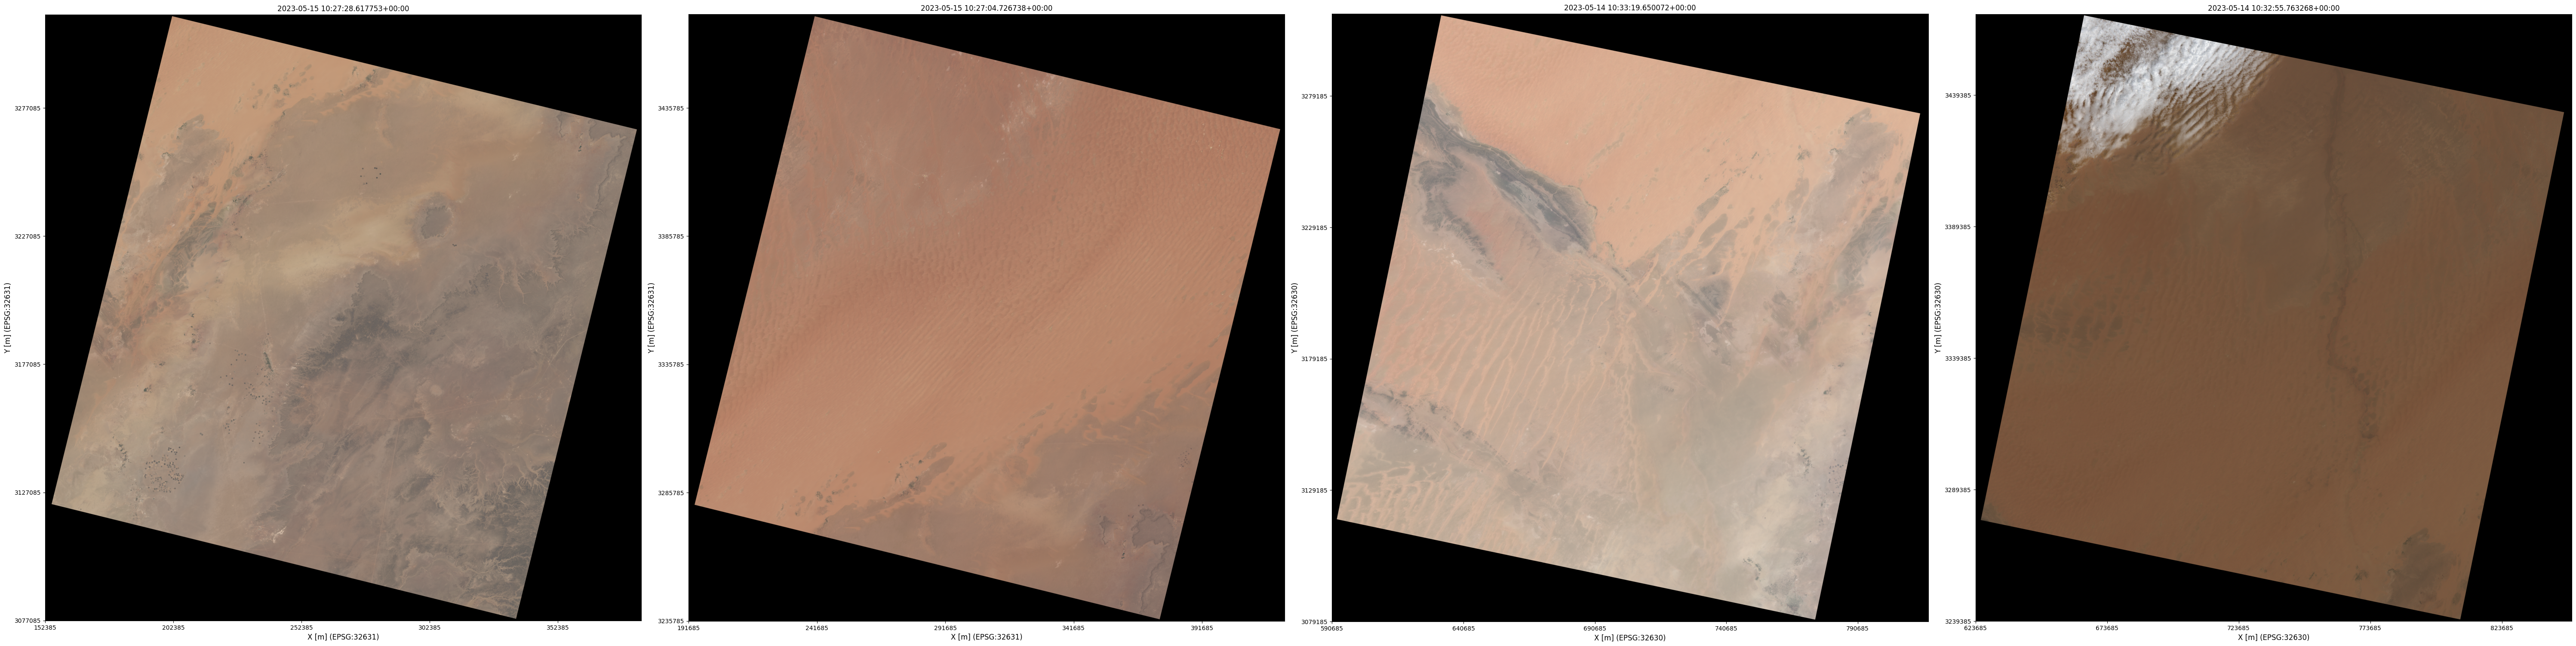

In [4]:
import matplotlib.pyplot as plt
f_scenes = sc.plot(band_selection=['red','green','blue'], figsize=(60,20))